# 09. 군집생존자료분석
- **군집생존자료 : 연구대상들이 군집을 이루고 있어, 같은 군집에 속한 연구 대상들의 생존시간이 유전적 요인이나 환경적 요인들에 의해 서로 연관되어있는 새존 자료**
    - 예: 독성실험에서 같은 부모로부터 태어난 새끼 실험체들의 건강상태 및 생존시간

In [8]:
library(tidyverse)
library(survival)

# 
### 9-1 군집생존자료 예시
#### ashkenzi 데이터 
- 특정 가문을 대상으로 유방암의 발생 위험에 대한 돌연변이 효과 연구자료

# 
- 1번 가족은 2명으로 구성 (73세, 40세), 유방암 병력(```brcancer```)은 없음, prodband(가계조사에서 계보의 시발점이 되는 사람)은 돌연변이 유전자가 없었음(```mutant```)
- 94번 가족중 한 명은 44세에 유방암이 있었으며, 다른 한 명은 45세로 유방암이 없음. 이 가족의 prodband는 돌연변이 유전자를 가지고 있음. 

In [5]:
data(ashkenazi, package = "asaur")
ashkenazi %>% filter(famID %in% c(1, 9, 94))

famID,brcancer,age,mutant
<int>,<int>,<int>,<int>
1,0,73,0
1,0,40,0
9,0,89,0
9,1,60,0
94,1,44,1
94,0,45,1


# 
#### retinopathy 데이터
- 당뇨 환자의 실명에 대한 레이저 치료 효과 연구 데이터
- 각 환자에게서 한쪽 눈을 무작위로 골라 레이저 치료, 다른쪽 눈은 치료하지 않음

# 
- 5번 환자는 46.23개월 관찰하였지만 실명하지 않음
- 14번 환자는 31.3개월에 치료받지 않은 눈(```treat``` = 0)을 실명(```status``` = 1)하였으나, 치료받은 눈은 42.5개월 까지 실명하지 않음
- 16번 환자는 42.27개월까지 양쪽 눈 모두 실명하지 않음

In [7]:
data(retinopathy, package = "survival")
retinopathy %>% head

,id,laser,eye,age,type,trt,futime,status,risk
,<int>,<fct>,<fct>,<int>,<fct>,<int>,<dbl>,<int>,<int>
1,5,argon,left,28,adult,1,46.23,0,9
2,5,argon,left,28,adult,0,46.23,0,9
3,14,argon,right,12,juvenile,1,42.50,0,8
4,14,argon,right,12,juvenile,0,31.30,1,6
5,16,xenon,right,9,juvenile,1,42.27,0,11
6,16,xenon,right,9,juvenile,0,42.27,0,11


# 
# 
### 9-2 주변모형
#### 주변모형 : 데이터에 있는 군집구조를 무시하고 비례위험 가정이 모든 대상을 만족하는 것으로 가정
- 콕스모형에 적합시켜 회귀계수를 구하고, 회귀계수에 대한 표준오차를 계산할 때 군집을 보정한 분산 및 표준오차를 계산
- **i번째 군집의 j번째 대상의 스코어잔차 $s_{ij}$**
### $s_{ij} = \delta_{ij}[z_{ij} - \bar{z}_{ij}]-\sum_{t_u \leq t_{ij}}[z_i - \bar{z_{ij}}] e^{z_i \beta}[\hat{H}_0(t_u) - \hat{H}(t_{u-1})]$
# 
- **C통계량**
### $C = \sum^G_{i=1} \sum^{n_i}_{j=1} \sum^{n_i}_{m=1} s_{ij} s_{im}$

# 
- **군집을 보정한 분산 $V^*$ (샌드위치 분산)**
### $V^* = \hat{V} C \hat{V}$

# 
# 
### 9-3 프레일티모형
#### 프레일티(frailty) : 랜덤효과, 각 대상환자 수준에서 미처 발견하지 못한 요인에 의한 것
- 생존모형에 있는 다른 예측변수들로는 설명되지 않는 다양성을 설명하기 위해 고안
- 예 : 나이와 흡연유무 2가지를 예측변수로 갖는 생존모형 
    - 33세 흡연자의 생존함수는 2가지 방법으로 생각할 수 있음
    1. 33세 흡연자 **개인의 생존함수**
    2. 많은 수로 구성된 **33세 흡연자 집단의 평균**
    - A, B가 둘다 33세 흡연자라면, 단지 두 사람의 관찰된 실패시간만 다른 것이 아니라, 두 사람의 생존함수도 다를 수 있음
        - A는 관찰되지 않은 어떤 요인들로 인해 위험함수와 생존함수가 달라져, B에 비해 더 허약할 수 있음 (more frail)
    - **관찰되지 않은 요인들이 추가적인 다양성에 기여해, 프레일티 성분이 없는 생존모형에서 예측한 것보다 생존시간의 변동이 더 클 수 있음**
    
# 

- **프레일티 $\alpha$는 위험함수에 영향을 미치는 관찰되지 않은 효과로, $\alpha > 0$이며, 평균이 1인 ($\mu = E(\alpha) = 1$)인 어떤 분포 $g(\alpha)$를 따른다고 가정**
    - **$\alpha$의 분산은 모수 $\theta$ 데이터부터 추정**
    - 개인의 위험함수와 생존함수는 프레일티에 의존하는 조건부함수가 되며, **위험함수는 $h(t | \alpha) = \alpha h(t)$가 되고, 생존함수 $S(t | \alpha) = S(t)^\alpha$**
    - **프레일티 $\alpha > 1$인 개인은 평균적인 프레일티 $\alpha = 1$을 갖는 사람에 비해 위험이 증가하고 생존확률이 감소**
    - **프레일티 $\alpha < 1$인 개인은 평균적인 프레일티를 갖는 사람에 비해 위험이 감소하고 생존확률이 증가**
    
# 
#### $\alpha > 1$
- **increased hazard : $\alpha h(t) > h(t)$**
- **decreased survival : $S(t)^\alpha < S(t)$**

# 
#### $\alpha < 1$
- **decreased hazard : $\alpha h(t) < h(t)$**
- **increased survival : $S(t)^\alpha > S(t)$**

# 
#### 프레일티모형에서는 개인 수준의 조건부생존함수 $S(t|\alpha)$와 구별하기 위해 집단 수준에서의 생존함수를 비조건부생존함수 $S_U (t)$로 구분
- $S_U (t)$는 집단의 평균을 반연
- 데이터로부터 프레일티 $g(\alpha)$가 선택되면, $S_U (t)$는 조건부생존함수 $S(t| \alpha)$와 $g(\alpha)$의 곱을 $\alpha$에 대하여 적분하여 구할 수 있음

### $S_U (t) = \int^{\infty}_{0} S(t | \alpha) g(\alpha) d\alpha$
### $h_U (t) = {{-d [S_U (t)]\;/\;dt}\over{S_U (t)}}$

# 
#### 프레일티 $\alpha$의 분포는 평균이 1이고 $\alpha > 0$인 모든 분포를 사용할 수 있음 (일반적으로 감마분포를 사용)

# 
# 
### 9-4 ashkenazi 분석

In [9]:
fit = coxph(Surv(age, brcancer) ~ mutant, ashkenazi)
summary(fit)

Call:
coxph(formula = Surv(age, brcancer) ~ mutant, data = ashkenazi)

  n= 3920, number of events= 473 

         coef exp(coef) se(coef)     z Pr(>|z|)    
mutant 1.1907    3.2895   0.1984 6.002 1.95e-09 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

       exp(coef) exp(-coef) lower .95 upper .95
mutant      3.29      0.304      2.23     4.853

Concordance= 0.523  (se = 0.006 )
Likelihood ratio test= 25.92  on 1 df,   p=4e-07
Wald test            = 36.03  on 1 df,   p=2e-09
Score (logrank) test = 40.49  on 1 df,   p=2e-10


# 
- 예측변수가 없는 영모형의 로그가능도 : -3579.7065
- 예측변수 ```mutant```가 포함된 모형의 로그가능도 : -3566.7454
- **가능도비검정 통계량 : $G2 = 2(-3566.755 + 3579.71) = 25.92\;\;\;$ ($df = 1 - 0$)**
    - 가능도비검정 : p-value < 0.05 => ```mutant```변수가 포함된 모형이 통계적으로 유의

In [10]:
fit$loglik

[1] -3579.707 -3566.745

# 
#### ```cluster()``` : 주변방법으로 군집효과 분석

# 
- ```robust se```가 결과에 추가됨
    - **표준콕스모형 추정치의 오차 (0.1984)와 비교하여 조금 높음 => 가족 내 군집효과는 적음**

In [11]:
fit2 = coxph(Surv(age, brcancer) ~ mutant + cluster(famID), ashkenazi)
summary(fit2)

Call:
coxph(formula = Surv(age, brcancer) ~ mutant, data = ashkenazi, 
    cluster = famID)

  n= 3920, number of events= 473 

         coef exp(coef) se(coef) robust se     z Pr(>|z|)    
mutant 1.1907    3.2895   0.1984    0.2023 5.886 3.96e-09 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

       exp(coef) exp(-coef) lower .95 upper .95
mutant      3.29      0.304     2.213      4.89

Concordance= 0.523  (se = 0.006 )
Likelihood ratio test= 25.92  on 1 df,   p=4e-07
Wald test            = 34.64  on 1 df,   p=4e-09
Score (logrank) test = 40.49  on 1 df,   p=2e-10,   Robust = 13.09  p=3e-04

  (Note: the likelihood ratio and score tests assume independence of
     observations within a cluster, the Wald and robust score tests do not).

# 
- **Wald 검정에 사용되는 z통계량은 회귀계수를 robust se로 나눈 것 $(z = {1.1907 \over 0.2023} = 5.886)$**
    - p-value는 표준정규분포와 비교하여 결정

- **p-value는 군집효과를 고려하기 전보다는 약간 높아졌으나 여전히 유의하므로, ```mutant```변수가 발생위험을 약 3.29배 높인다고 할 수 있다**

In [12]:
pnorm(-abs(5.886), lower.tail = T) * 2

[1] 3.956543e-09

# 
#### ```frailty(, ... dist)``` : 프레일티모형으로 군집효과 분석
- ```dist``` : 감마분포를 디폴트로 사용, ("gamma", "gaussian")

# 
- **회귀계수의 추정치는 표준콕스모형과 동일하지만, frailty가 포함된 모형에서는 표준오차의 추정량을 2개 제시**
    - **```se(coef)``` : 일반적으로 선호되는 추정량**
    - **```se2``` : 샌드위치 추정량**
    - **랜덤효과의 분산 (Variance of random effect) : 0.49** / **p-value : 0.31** => 귀무가설 ($H_0 : \theta = 0$)기각 불가

In [14]:
fit3 = coxph(Surv(age, brcancer) ~ mutant + frailty(famID), ashkenazi)
summary(fit3)

Call:
coxph(formula = Surv(age, brcancer) ~ mutant + frailty(famID), 
    data = ashkenazi)

  n= 3920, number of events= 473 

               coef  se(coef) se2    Chisq  DF    p      
mutant         1.272 0.2317   0.2004  30.13   1.0 4.0e-08
frailty(famID)                       221.50 211.6 3.1e-01

       exp(coef) exp(-coef) lower .95 upper .95
mutant     3.567     0.2804     2.265     5.617

Iterations: 6 outer, 26 Newton-Raphson
     Variance of random effect= 0.4937594   I-likelihood = -3564.3 
Degrees of freedom for terms=   0.7 211.6 
Concordance= 0.938  (se = 0.004 )
Likelihood ratio test= 400.2  on 212.4 df,   p=1e-13


# 
#### ```coxme()``` : 프레일티모형 적합
- ```mutant + (1|famID)``` : 고정효과
- ```(1|famID)``` : 내포된 랜덤효과
- ```iterations``` : 적합과정 중 수렴에 관한 정보
- ```Log-likelihood``` :
    1. ```NULL``` : 공변량이 없는 영모형의 부분로그가능도
    2. ```Integrated``` : 랜덤효과가 통합된 모형의 로그가능도
    3. ```Fitted``` : 적합한 모형의 로그가능도

In [19]:
library(coxme)

In [20]:
fit4 = coxme(Surv(age, brcancer) ~ mutant + (1|famID), ashkenazi)
summary(fit4)

Cox mixed-effects model fit by maximum likelihood
  Data: ashkenazi
  events, n = 473, 3920
  Iterations= 10 63 
                    NULL Integrated    Fitted
Log-likelihood -3579.707  -3564.622 -3411.522

                   Chisq    df          p   AIC     BIC
Integrated loglik  30.17   2.0 2.8100e-07 26.17   17.85
 Penalized loglik 336.37 150.1 2.2204e-16 36.16 -588.13

Model:  Surv(age, brcancer) ~ mutant + (1 | famID) 
Fixed coefficients
           coef exp(coef)  se(coef)    z       p
mutant 1.236609  3.443914 0.2205358 5.61 2.1e-08

Random effects
 Group Variable  Std Dev   Variance 
 famID Intercept 0.5912135 0.3495334


- 이 모형에 포함된 랜덤효과의 통계적 유의성은 통합된 로그가능도(-3564.622)와, ```mutant```를 공변량으로 하는 표준콕스모형의 로그가능도(-3566.745)의 차이의 2배에 해당하는 통계량 $G2 = 2(-3564.622 + 3566.745) = 4.246$을 계산하여 자유도를 1로 하는 카이제곱분포로 부터 계산
    - **p-value : 0.039 => 이전의 ```frailty()```를 사용한 모형의 p-value와 다름 => ```coxme()```에 의한 결과를 우선**

In [23]:
pchisq(4.246, 1, lower.tail = F)

[1] 0.03934289

- Integrated loglik의 카이제곱 통계량 30.17은 통합된 로그가능도와 영모형의 로그가능도 차이의 2배 (고정효과와 랜덤효과의 통합검정)
- **고정효과의 회귀계수에 ```mutatnt```에 대한 회귀계수는 1.237, 위험비는 3.44 => ```mutant```가 1인 가족이, 그렇지 않은 가족에 비해 발생 위험비가 3.44배 높고, Wald 검정에서 매우 유의함을 보임**
- 랜덤효과의 분산 : 0.35 / 표준오차 : 0.59

# 
# 
### 9-5 retinopathy 분석

- 상호작용만이 통계적으로 유의

In [27]:
fit0 = coxph(Surv(futime, status) ~ trt*type, retinopathy)
fit0

Call:
coxph(formula = Surv(futime, status) ~ trt * type, data = retinopathy)

                 coef exp(coef) se(coef)      z      p
trt           -0.4250    0.6538   0.2177 -1.952 0.0509
typeadult      0.3413    1.4067   0.1992  1.713 0.0867
trt:typeadult -0.8459    0.4292   0.3509 -2.411 0.0159

Likelihood ratio test=28.49  on 3 df, p=2.87e-06
n= 394, number of events= 155 

In [28]:
fit0$loglik

[1] -867.9858 -853.7422

# 
#### 프레일티모형
- 프레일티 (```frailty(id)```)의 분산추정량 : 0.9258 / p-value : 0.0098 => 귀무가설 ($H_0 : \theta = 0$) => 각 환자들은 서로 다른 시력상실 반응을 보임 => **프레일티 효과가 유의하다 (랜덤효과가 있다)**

In [29]:
fit1 = coxph(Surv(futime, status) ~ trt * type + frailty(id), retinopathy)
summary(fit1)

Call:
coxph(formula = Surv(futime, status) ~ trt * type + frailty(id), 
    data = retinopathy)

  n= 394, number of events= 155 

              coef    se(coef) se2    Chisq  DF    p     
trt           -0.5059 0.2255   0.2207   5.03  1.00 0.0250
typeadult      0.3969 0.2591   0.2053   2.35  1.00 0.1300
frailty(id)                           122.55 88.58 0.0098
trt:typeadult -0.9850 0.3618   0.3553   7.41  1.00 0.0065

              exp(coef) exp(-coef) lower .95 upper .95
trt              0.6030     1.6584    0.3876    0.9380
typeadult        1.4872     0.6724    0.8949    2.4714
trt:typeadult    0.3734     2.6779    0.1838    0.7588

Iterations: 6 outer, 31 Newton-Raphson
     Variance of random effect= 0.92598   I-likelihood = -847 
Degrees of freedom for terms=  1.0  0.6 88.6  1.0 
Concordance= 0.86  (se = 0.014 )
Likelihood ratio test= 218.4  on 91.13 df,   p=2e-12


# 
#### 위험함수
### $h_U (t) = h_{U0}(t)\;exp(-0.506 trt + 0.397 + typeadult - 0.985 trt\times typeadult)$

# 
#### 치료 및 당뇨 type에 따른 위험비 구분
- juvenile, not treated : $HR = exp(0)=1$
- juvenile, treated : $HR = 0.6030$
- adult onset, not treated : $HR = 1.4872$
- adult onset, treated : $HR = 0.6030 \times 1.4872 \times 0.3734 = 0.3348$

# 
#### 당뇨의 종류는 시력상실에 유의한 영향을 주지 못하며, 레이저 치료는 시력상실을 감소
- 레이저 치료는 1형 당뇨와 2형 당뇨에서 모두 시력상실의 위험을 감소시키며, 성인에게 더더욱 효과적

# 
#### 주변모형에 적합
- 프레일티모형과 유사
- **프레일티모형은 개별효과로 환자 내 두 치료방법의 위험률을 추정하지만, 주변모형에서는 치료를 받은 군과 치료를 받지 않은 군의 평균효과를 추정**

In [30]:
fit2 = coxph(Surv(futime, status) ~ trt * type + cluster(id), retinopathy)
summary(fit2)

Call:
coxph(formula = Surv(futime, status) ~ trt + type + trt:type, 
    data = retinopathy, cluster = id)

  n= 394, number of events= 155 

                 coef exp(coef) se(coef) robust se      z Pr(>|z|)   
trt           -0.4250    0.6538   0.2177    0.1850 -2.297  0.02160 * 
typeadult      0.3413    1.4067   0.1992    0.1958  1.743  0.08129 . 
trt:typeadult -0.8459    0.4292   0.3509    0.3036 -2.786  0.00534 **
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

              exp(coef) exp(-coef) lower .95 upper .95
trt              0.6538     1.5296    0.4549    0.9395
typeadult        1.4067     0.7109    0.9585    2.0646
trt:typeadult    0.4292     2.3301    0.2367    0.7782

Concordance= 0.613  (se = 0.019 )
Likelihood ratio test= 28.49  on 3 df,   p=3e-06
Wald test            = 34.88  on 3 df,   p=1e-07
Score (logrank) test = 28.44  on 3 df,   p=3e-06,   Robust = 30.29  p=1e-06

  (Note: the likelihood ratio and score tests assume independence of
     observ

#### ```trt```와 ```type```에 따른 생존 비교
- 최상단으 곡선과, 최하단의 곡선이 2형 당뇨의 생존곡선, 가운데 2개가 1형 당뇨의 생존곡선
- 프레일티모형과 마찬가지로 레이저 치료는 1형 당뇨와 2형당뇨 모두 시력상실의 위험을 감소시키며, 특히 성인에게 효과적

In [31]:
library(autoReg)

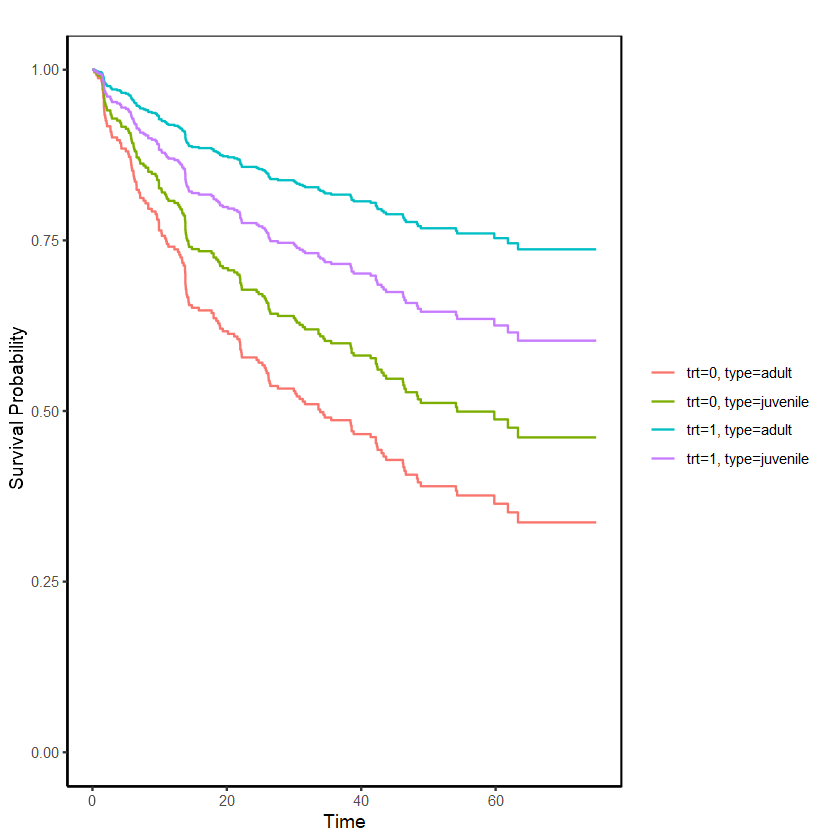

In [32]:
adjustedPlot(fit2, xnames = c("trt", "type"))

# 
#### 콕스혼합모형애 적합
- **치료를 한 눈은 실명의 위험비가 0.606로 실명위험이 감소**
- **성인 당뇨에서 실명의 위험비는 1.49이지만, 통계적 유의성은 없음**
- 치료는 1형 당뇨보다 성인형 당뇨에서 더 큰효과

In [34]:
result = coxme(Surv(futime, status) ~ trt * type + (1|id), retinopathy)
result

Cox mixed-effects model fit by maximum likelihood
  Data: retinopathy
  events, n = 155, 394
  Iterations= 7 39 
                    NULL Integrated    Fitted
Log-likelihood -867.9858  -847.4188 -761.2903

                   Chisq    df          p   AIC     BIC
Integrated loglik  41.13  4.00 2.5215e-08 33.13   20.96
 Penalized loglik 213.39 78.04 1.6209e-14 57.31 -180.20

Model:  Surv(futime, status) ~ trt * type + (1 | id) 
Fixed coefficients
                    coef exp(coef)  se(coef)     z      p
trt           -0.5004347 0.6062670 0.2254102 -2.22 0.0260
typeadult      0.3991886 1.4906147 0.2457170  1.62 0.1000
trt:typeadult -0.9669851 0.3802277 0.3616241 -2.67 0.0075

Random effects
 Group Variable  Std Dev   Variance 
 id    Intercept 0.9177088 0.8421895

# 
#### 와이블모수모형 적합 (후진제거법)

In [35]:
fit = survreg(Surv(futime, status) ~ trt * type + laser + eye + risk + cluster(id), retinopathy)
summary(fit)


Call:
survreg(formula = Surv(futime, status) ~ trt + type + laser + 
    eye + risk + trt:type, data = retinopathy, cluster = id)
                Value Std. Err (Naive SE)     z      p
(Intercept)    6.4746   0.7773     0.7381  8.33 <2e-16
trt            0.5056   0.2316     0.2665  2.18 0.0290
typeadult     -0.5091   0.2441     0.2448 -2.09 0.0370
laserargon    -0.2192   0.2267     0.1969 -0.97 0.3335
eyeleft       -0.2474   0.2207     0.2034 -1.12 0.2623
risk          -0.1801   0.0745     0.0696 -2.42 0.0156
trt:typeadult  1.1053   0.3814     0.4313  2.90 0.0038
Log(scale)     0.1943   0.0601     0.0721  3.23 0.0012

Scale= 1.21 

Weibull distribution
Loglik(model)= -827.8   Loglik(intercept only)= -848
	Chisq= 40.29 on 6 degrees of freedom, p= 4e-07 
(Loglikelihood assumes independent observations)
Number of Newton-Raphson Iterations: 5 
n= 394 


In [36]:
final = step(fit)

Start:  AIC=1671.65
Surv(futime, status) ~ trt + type + laser + eye + risk + trt:type

           Df    AIC
- laser     1 1670.9
- eye       1 1671.2
<none>        1671.7
- trt:type  1 1676.6
- risk      1 1676.6

Step:  AIC=1670.89
Surv(futime, status) ~ trt + type + eye + risk + trt:type

           Df    AIC
- eye       1 1670.7
<none>        1670.9
- trt:type  1 1675.7
- risk      1 1675.9

Step:  AIC=1670.7
Surv(futime, status) ~ trt + type + risk + trt:type

           Df    AIC
<none>        1670.7
- trt:type  1 1675.5
- risk      1 1676.3


In [37]:
summary(final)


Call:
survreg(formula = Surv(futime, status) ~ trt + type + risk + 
    trt:type, data = retinopathy, cluster = id)
                Value Std. Err (Naive SE)     z      p
(Intercept)    6.2806   0.7532     0.7252  8.34 <2e-16
trt            0.5083   0.2337     0.2673  2.18 0.0296
typeadult     -0.4716   0.2444     0.2444 -1.93 0.0537
risk          -0.1873   0.0743     0.0694 -2.52 0.0117
trt:typeadult  1.0974   0.3835     0.4324  2.86 0.0042
Log(scale)     0.1973   0.0602     0.0721  3.28 0.0011

Scale= 1.22 

Weibull distribution
Loglik(model)= -829.4   Loglik(intercept only)= -848
	Chisq= 37.24 on 4 degrees of freedom, p= 1.6e-07 
(Loglikelihood assumes independent observations)
Number of Newton-Raphson Iterations: 5 
n= 394 


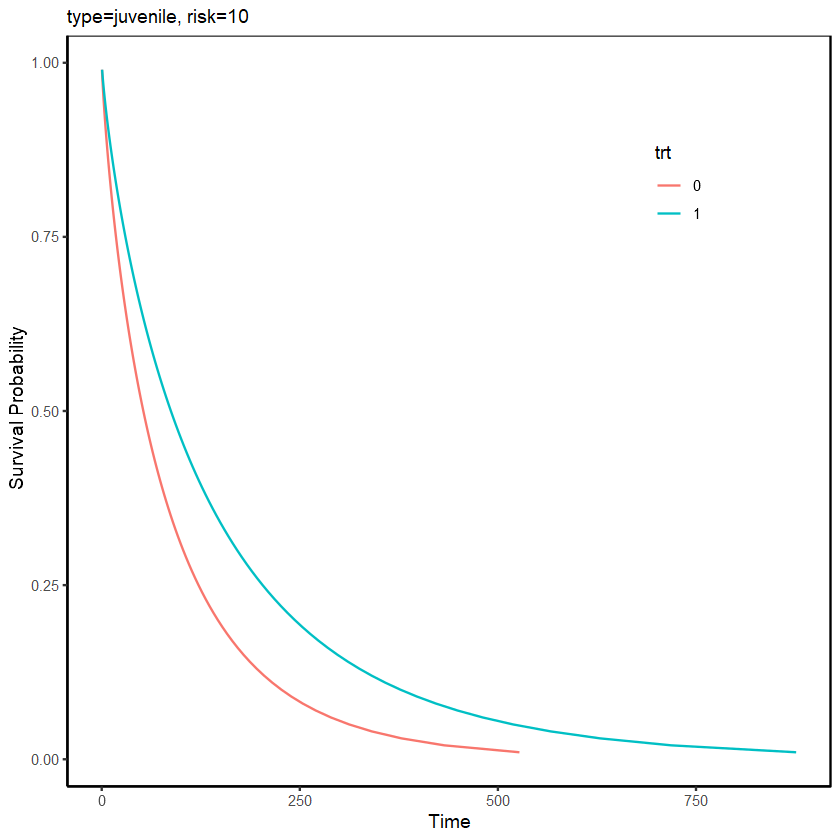

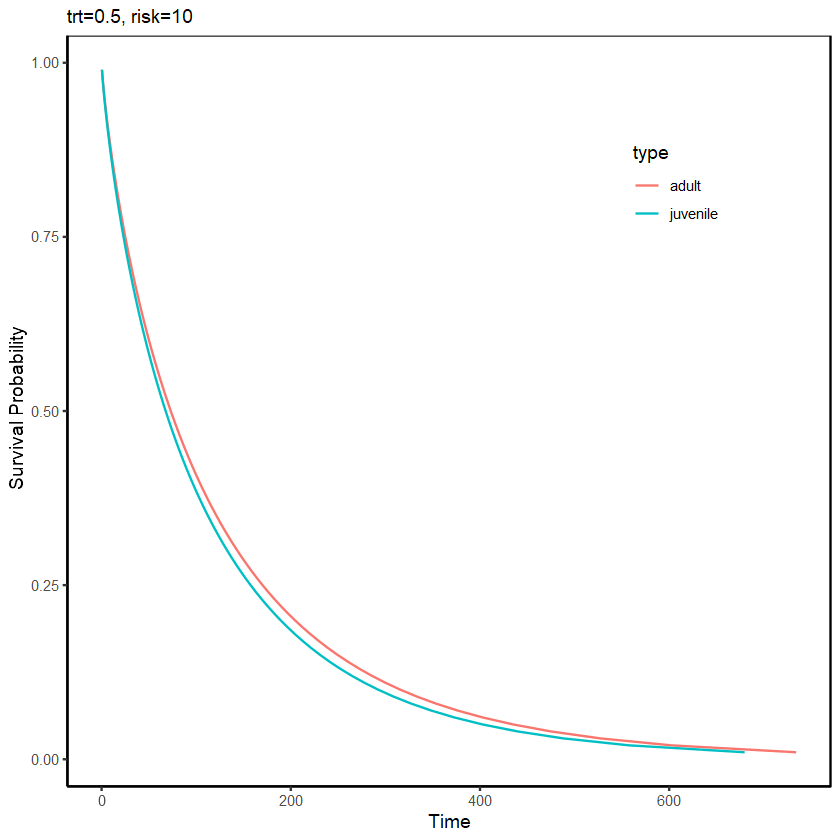

In [38]:
adjustedPlot(final, xnames = "trt")
adjustedPlot(final, xnames = "type")

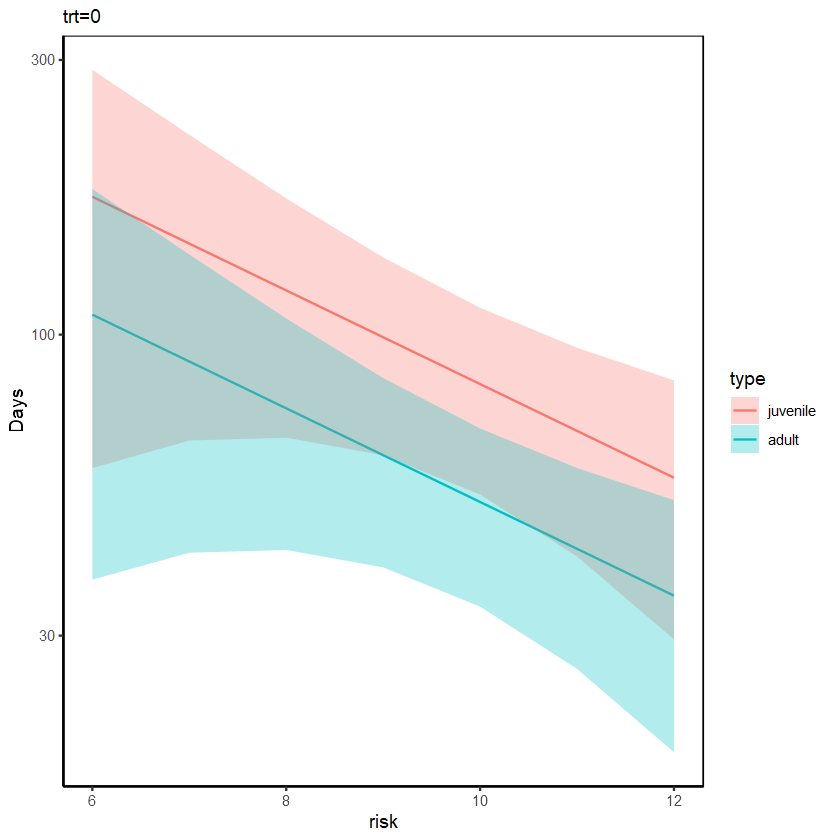

In [44]:
showEffect(final)